SVM

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


train accuracy:  0.9654989384288747
test accuracy:  0.6883582089552239
f1 score:  0.6883582089552239
train accuracy:  0.9642383227176221
test accuracy:  0.7074626865671642
f1 score:  0.7074626865671642
train accuracy:  0.9651671974522293
test accuracy:  0.702089552238806
f1 score:  0.702089552238806
train accuracy:  0.9644373673036093
test accuracy:  0.706865671641791
f1 score:  0.706865671641791
train accuracy:  0.964968152866242
test accuracy:  0.7080597014925373
f1 score:  0.7080597014925373
train accuracy:  0.964968152866242
test accuracy:  0.6943283582089552
f1 score:  0.6943283582089552
train accuracy:  0.964968152866242
test accuracy:  0.7104477611940299
f1 score:  0.7104477611940299
train accuracy:  0.9649041332183375
test accuracy:  0.6995221027479092
f1 score:  0.6995221027479092
train accuracy:  0.9647714456312612
test accuracy:  0.7198327359617682
f1 score:  0.7198327359617682
train accuracy:  0.9657002587407948
test accuracy:  0.6983273596176822
f1 score:  0.69832735961768

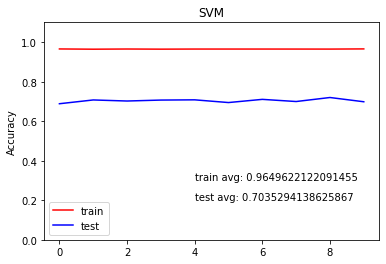

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from statistics import mean
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import string


def preprocess_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]

    return " ".join(lemma_words)


def preprocess_corpus():
    companies = pd.read_csv("companies_and_social_media.csv")
    tweets = pd.read_csv("all_tweets.csv")
    companies = companies.dropna(subset=["Twitter"])
    twitter_score = companies.set_index("Twitter").to_dict()["Performance.Band"]
    tweets["score"] = tweets["user"].map(twitter_score)
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    corpus = tweets[["user", "content", "score"]]
    return corpus


def develop_model():
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"], corpus["score"], test_size=0.2)

    kf = KFold(n_splits=10,shuffle=True, random_state = 0)
    kf.split(corpus['content'])

    # Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
    train_acc_list = []
    test_acc_list = []
    f1_score_list = []
 
    # Iterate over each train-test split
    for train_index, test_index in kf.split(corpus['content']):
        # Split train-test
        train_set, test_set = corpus['content'].iloc[train_index], corpus['content'].iloc[test_index]
        train_label, test_label = corpus['score'].iloc[train_index], corpus['score'].iloc[test_index]
    
    
        encoder = LabelEncoder()
        encoder.fit(corpus["score"])
        test_label = encoder.transform(test_label)
        train_label = encoder.transform(train_label)

        tfidf_vect = TfidfVectorizer()
        tfidf_vect.fit(corpus["content"])
        train_set_tfidf = tfidf_vect.transform(train_set)
        test_set_tfidf = tfidf_vect.transform(test_set)

        '''## Standardize the data
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler(with_mean = False)
        # Fit on training set only
        scaler.fit(train_set_tfidf)
        # Apply transform to  training and test sets
        train_set_tfidf = scaler.transform(train_set_tfidf)
        test_set_tfidf = scaler.transform(test_set_tfidf)'''
        

        '''## Apply PCA to reduce dimensionality
        from sklearn.decomposition import PCA
        # Make an instance of the Model with 95% of variance retained
        pca = PCA(.95)
        # Fit to training set only
        pca.fit(train_set_tfidf)
        # Apply transform to training and test sets
        train_set_tfidf = pca.transform(train_set_tfidf)
        test_set_tfidf = pca.transform(test_set_tfidf)'''
        
        '''## Apply Truncated SVD to reduce dimensionality, since PCA didn't work with sparse data
        from sklearn.decomposition import TruncatedSVD
        svd = TruncatedSVD(n_components = 100)
        svd.fit(train_set_tfidf)
        train_set_tfidf = svd.transform(train_set_tfidf)
        test_set_tfidf = svd.transform(test_set_tfidf)'''
        
        
        clf = svm.SVC()
        clf.fit(train_set_tfidf, train_label)
        train_predictions = clf.predict(train_set_tfidf)
        test_predictions = clf.predict(test_set_tfidf)
        
        train_accuracy = accuracy_score(train_predictions, train_label)
        test_accuracy = accuracy_score(test_predictions, test_label)
        f1 = f1_score(test_label, test_predictions, average = 'micro')
        
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)
        f1_score_list.append(f1)
        
        
        print('train accuracy: ', train_accuracy)
        print('test accuracy: ', test_accuracy)
        print('f1 score: ', f1)
        
    
    train_avg = 'train avg: ' + str(mean(train_acc_list))
    test_avg = 'test avg: ' + str(mean(test_acc_list))
    f1_avg = 'f1 avg: ' + str(mean(f1_score_list))
    
    
    plt.plot(train_acc_list, color = 'r', label = 'train')
    plt.ylabel('Accuracy')
    plt.plot(test_acc_list, color = 'b', label = 'test')
    ax = plt.gca()
    #plt.plot(f1_score_list, color = 'g', label = 'f1')
    ax.set_ylim([0, 1.1])
    plt.legend()
    plt.text(4, 0.3, train_avg)
    plt.text(4, 0.2, test_avg)
    #plt.text(4, 0.1, f1_avg)
    plt.title('SVM')
    plt.show()
    

'''    d = {"content": train_set, "prediction": train_label}
    f = {"content": test_set, "prediction": test_label}
    df = pd.DataFrame(data=d)
    df2 = pd.DataFrame(data=f)
    df = df.append(df2, ignore_index=True)
    tweets_summary = corpus.join(df.set_index("content"), on="content")

    tweets_summary["score"] = encoder.transform(tweets_summary["score"].tolist())
    companies = np.unique(tweets_summary["user"])
    companies_summary = pd.DataFrame(columns=["user", "score", "prediction"])
    for entry in companies:
        company = tweets_summary[tweets_summary["user"] == entry]
        companies_summary = companies_summary.append({"user": entry, "score": company["score"].mode(), "prediction": company["prediction"].mode()}, ignore_index=True)
    print(accuracy_score(np.array(companies_summary["score"].tolist()), np.array(companies_summary["prediction"].tolist())))

    tweets_summary["score"] = encoder.inverse_transform(tweets_summary["score"].tolist())
    tweets_summary["prediction"] = encoder.inverse_transform(tweets_summary["prediction"].tolist())
    companies_summary["score"] = encoder.inverse_transform(companies_summary["score"].tolist())
    companies_summary["prediction"] = encoder.inverse_transform(companies_summary["prediction"].tolist())

    tweets_summary.to_csv("tweets_summary.csv")
    companies_summary.to_csv("companies_summary.csv")'''
    

def main():
    develop_model()



if __name__ == '__main__':
    main()

SVM + truncated SVD

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


train accuracy:  0.9470541401273885
test accuracy:  0.715820895522388
f1 score:  0.715820895522388
train accuracy:  0.9447319532908705
test accuracy:  0.7295522388059702
f1 score:  0.7295522388059702
train accuracy:  0.947452229299363
test accuracy:  0.7259701492537314
f1 score:  0.7259701492537313
train accuracy:  0.9456608280254777
test accuracy:  0.7301492537313433
f1 score:  0.7301492537313433
train accuracy:  0.9461916135881104
test accuracy:  0.7229850746268657
f1 score:  0.7229850746268657
train accuracy:  0.9469877919320594
test accuracy:  0.7128358208955224
f1 score:  0.7128358208955224
train accuracy:  0.9475185774946921
test accuracy:  0.7295522388059702
f1 score:  0.7295522388059702
train accuracy:  0.9481854972467326
test accuracy:  0.7234169653524493
f1 score:  0.7234169653524493
train accuracy:  0.9471239965501227
test accuracy:  0.7395459976105138
f1 score:  0.7395459976105138
train accuracy:  0.9475220593113515
test accuracy:  0.7228195937873357
f1 score:  0.7228195937

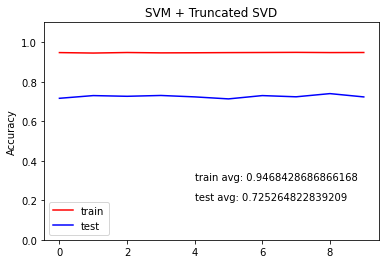

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from statistics import mean
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import string


def preprocess_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]

    return " ".join(lemma_words)


def preprocess_corpus():
    companies = pd.read_csv("companies_and_social_media.csv")
    tweets = pd.read_csv("all_tweets.csv")
    companies = companies.dropna(subset=["Twitter"])
    twitter_score = companies.set_index("Twitter").to_dict()["Performance.Band"]
    tweets["score"] = tweets["user"].map(twitter_score)
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    corpus = tweets[["user", "content", "score"]]
    return corpus


def develop_model():
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"], corpus["score"], test_size=0.2)

    kf = KFold(n_splits=10,shuffle=True, random_state = 0)
    kf.split(corpus['content'])

    # Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
    train_acc_list = []
    test_acc_list = []
    f1_score_list = []
 
    # Iterate over each train-test split
    for train_index, test_index in kf.split(corpus['content']):
        # Split train-test
        train_set, test_set = corpus['content'].iloc[train_index], corpus['content'].iloc[test_index]
        train_label, test_label = corpus['score'].iloc[train_index], corpus['score'].iloc[test_index]
    
    
        encoder = LabelEncoder()
        encoder.fit(corpus["score"])
        test_label = encoder.transform(test_label)
        train_label = encoder.transform(train_label)

        tfidf_vect = TfidfVectorizer()
        tfidf_vect.fit(corpus["content"])
        train_set_tfidf = tfidf_vect.transform(train_set)
        test_set_tfidf = tfidf_vect.transform(test_set)
        
        ## Apply Truncated SVD to reduce dimensionality, since PCA didn't work with sparse data
        ## 3500 components (worked best through trial and error)
        from sklearn.decomposition import TruncatedSVD
        svd = TruncatedSVD(n_components = 3500)
        svd.fit(train_set_tfidf)
        train_set_tfidf = svd.transform(train_set_tfidf)
        test_set_tfidf = svd.transform(test_set_tfidf)
        
        
        clf = svm.SVC()
        clf.fit(train_set_tfidf, train_label)
        train_predictions = clf.predict(train_set_tfidf)
        test_predictions = clf.predict(test_set_tfidf)
        
        train_accuracy = accuracy_score(train_predictions, train_label)
        test_accuracy = accuracy_score(test_predictions, test_label)
        f1 = f1_score(test_label, test_predictions, average = 'micro')
        
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)
        f1_score_list.append(f1)
        
        
        print('train accuracy: ', train_accuracy)
        print('test accuracy: ', test_accuracy)
        print('f1 score: ', f1)
        
        
    
    train_avg = 'train avg: ' + str(mean(train_acc_list))
    test_avg = 'test avg: ' + str(mean(test_acc_list))
    f1_avg = 'f1 avg: ' + str(mean(f1_score_list))
    
    plt.plot(train_acc_list, color = 'r', label = 'train')
    plt.ylabel('Accuracy')
    plt.plot(test_acc_list, color = 'b', label = 'test')
    ax = plt.gca()
    #plt.plot(f1_score_list, color = 'g', label = 'f1')
    ax.set_ylim([0, 1.1])
    plt.legend()
    plt.text(4, 0.3, train_avg)
    plt.text(4, 0.2, test_avg)
    #plt.text(4, 0.1, f1_avg)
    plt.title('SVM + Truncated SVD')
    plt.show()
    


'''    d = {"content": train_set, "prediction": train_label}
    f = {"content": test_set, "prediction": test_label}
    df = pd.DataFrame(data=d)
    df2 = pd.DataFrame(data=f)
    df = df.append(df2, ignore_index=True)
    tweets_summary = corpus.join(df.set_index("content"), on="content")

    tweets_summary["score"] = encoder.transform(tweets_summary["score"].tolist())
    companies = np.unique(tweets_summary["user"])
    companies_summary = pd.DataFrame(columns=["user", "score", "prediction"])
    for entry in companies:
        company = tweets_summary[tweets_summary["user"] == entry]
        companies_summary = companies_summary.append({"user": entry, "score": company["score"].mode(), "prediction": company["prediction"].mode()}, ignore_index=True)
    print(accuracy_score(np.array(companies_summary["score"].tolist()), np.array(companies_summary["prediction"].tolist())))

    tweets_summary["score"] = encoder.inverse_transform(tweets_summary["score"].tolist())
    tweets_summary["prediction"] = encoder.inverse_transform(tweets_summary["prediction"].tolist())
    companies_summary["score"] = encoder.inverse_transform(companies_summary["score"].tolist())
    companies_summary["prediction"] = encoder.inverse_transform(companies_summary["prediction"].tolist())

    tweets_summary.to_csv("tweets_summary.csv")
    companies_summary.to_csv("companies_summary.csv")'''
    

def main():
    develop_model()



if __name__ == '__main__':
    main()

Random Forest

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


train accuracy:  0.9877255838641189
test accuracy:  0.7253731343283583
f1 score:  0.7253731343283581
train accuracy:  0.9869294055201698
test accuracy:  0.7492537313432835
f1 score:  0.7492537313432835
train accuracy:  0.9877255838641189
test accuracy:  0.7343283582089553
f1 score:  0.7343283582089553
train accuracy:  0.9871284501061571
test accuracy:  0.7468656716417911
f1 score:  0.7468656716417911
train accuracy:  0.9874601910828026
test accuracy:  0.7271641791044776
f1 score:  0.7271641791044776
train accuracy:  0.9871284501061571
test accuracy:  0.724776119402985
f1 score:  0.724776119402985
train accuracy:  0.9869294055201698
test accuracy:  0.7432835820895523
f1 score:  0.7432835820895523
train accuracy:  0.9875937106083725
test accuracy:  0.7270011947431302
f1 score:  0.7270011947431303
train accuracy:  0.9873283354342202
test accuracy:  0.7604540023894862
f1 score:  0.7604540023894862
train accuracy:  0.9877927419889869
test accuracy:  0.7252090800477897
f1 score:  0.725209080

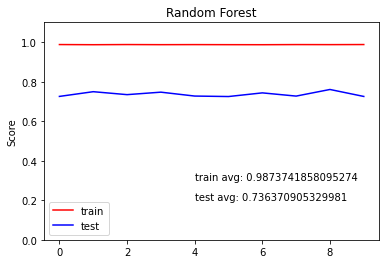

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from statistics import mean
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import string

from sklearn.ensemble import RandomForestClassifier


def preprocess_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]

    return " ".join(lemma_words)


def preprocess_corpus():
    companies = pd.read_csv("companies_and_social_media.csv")
    tweets = pd.read_csv("all_tweets.csv")
    companies = companies.dropna(subset=["Twitter"])
    twitter_score = companies.set_index("Twitter").to_dict()["Performance.Band"]
    tweets["score"] = tweets["user"].map(twitter_score)
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    corpus = tweets[["user", "content", "score"]]
    return corpus


def develop_model():
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"], corpus["score"], test_size=0.2)

    kf = KFold(n_splits=10,shuffle=True, random_state = 0)
    kf.split(corpus['content'])

    # Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
    train_acc_list = []
    test_acc_list = []
    f1_score_list = []
 
    # Iterate over each train-test split
    for train_index, test_index in kf.split(corpus['content']):
        # Split train-test
        train_set, test_set = corpus['content'].iloc[train_index], corpus['content'].iloc[test_index]
        train_label, test_label = corpus['score'].iloc[train_index], corpus['score'].iloc[test_index]
    
    
        encoder = LabelEncoder()
        encoder.fit(corpus["score"])
        test_label = encoder.transform(test_label)
        train_label = encoder.transform(train_label)

        tfidf_vect = TfidfVectorizer()
        tfidf_vect.fit(corpus["content"])
        train_set_tfidf = tfidf_vect.transform(train_set)
        test_set_tfidf = tfidf_vect.transform(test_set)

        clf = RandomForestClassifier()
        clf.fit(train_set_tfidf, train_label)
        train_predictions = clf.predict(train_set_tfidf)
        test_predictions = clf.predict(test_set_tfidf)
        
        train_accuracy = accuracy_score(train_predictions, train_label)
        test_accuracy = accuracy_score(test_predictions, test_label)
        f1 = f1_score(test_label, test_predictions, average = 'micro')
        
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)
        f1_score_list.append(f1)
        
        print('train accuracy: ', train_accuracy)
        print('test accuracy: ', test_accuracy)
        print('f1 score: ', f1)
    
    
    train_avg = 'train avg: ' + str(mean(train_acc_list))
    test_avg = 'test avg: ' + str(mean(test_acc_list))
    f1_avg = 'f1 avg: ' + str(mean(f1_score_list))
    
    
    plt.plot(train_acc_list, color = 'r', label = 'train')
    plt.ylabel('Score')
    plt.plot(test_acc_list, color = 'b', label = 'test')
    ax = plt.gca()
    #plt.plot(f1_score_list, color = 'g', label = 'f1')
    ax.set_ylim([0, 1.1])
    plt.legend()
    plt.text(4, 0.3, train_avg)
    plt.text(4, 0.2, test_avg)
    #plt.text(4, 0.1, f1_avg)
    plt.title('Random Forest')
    plt.show()
    


'''    d = {"content": train_set, "prediction": train_label}
    f = {"content": test_set, "prediction": test_label}
    df = pd.DataFrame(data=d)
    df2 = pd.DataFrame(data=f)
    df = df.append(df2, ignore_index=True)
    tweets_summary = corpus.join(df.set_index("content"), on="content")

    tweets_summary["score"] = encoder.transform(tweets_summary["score"].tolist())
    companies = np.unique(tweets_summary["user"])
    companies_summary = pd.DataFrame(columns=["user", "score", "prediction"])
    for entry in companies:
        company = tweets_summary[tweets_summary["user"] == entry]
        companies_summary = companies_summary.append({"user": entry, "score": company["score"].mode(), "prediction": company["prediction"].mode()}, ignore_index=True)
    print(accuracy_score(np.array(companies_summary["score"].tolist()), np.array(companies_summary["prediction"].tolist())))

    tweets_summary["score"] = encoder.inverse_transform(tweets_summary["score"].tolist())
    tweets_summary["prediction"] = encoder.inverse_transform(tweets_summary["prediction"].tolist())
    companies_summary["score"] = encoder.inverse_transform(companies_summary["score"].tolist())
    companies_summary["prediction"] = encoder.inverse_transform(companies_summary["prediction"].tolist())

    tweets_summary.to_csv("tweets_summary.csv")
    companies_summary.to_csv("companies_summary.csv")'''


def main():
    develop_model()



if __name__ == '__main__':
    main()


Random Forest + Truncated SVD

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


train accuracy:  0.9877255838641189
test accuracy:  0.4692537313432836
f1 score:  0.4692537313432836
train accuracy:  0.9869294055201698
test accuracy:  0.4955223880597015
f1 score:  0.4955223880597015
train accuracy:  0.9877255838641189
test accuracy:  0.5026865671641791
f1 score:  0.5026865671641791
train accuracy:  0.9871284501061571
test accuracy:  0.4955223880597015
f1 score:  0.4955223880597015
train accuracy:  0.9874601910828026
test accuracy:  0.49791044776119403
f1 score:  0.49791044776119403
train accuracy:  0.9871284501061571
test accuracy:  0.47402985074626863
f1 score:  0.47402985074626863
train accuracy:  0.9869294055201698
test accuracy:  0.506268656716418
f1 score:  0.506268656716418
train accuracy:  0.9875937106083725
test accuracy:  0.4874551971326165
f1 score:  0.4874551971326165
train accuracy:  0.9873283354342202
test accuracy:  0.5101553166069295
f1 score:  0.5101553166069295
train accuracy:  0.9877927419889869
test accuracy:  0.460573476702509
f1 score:  0.460573

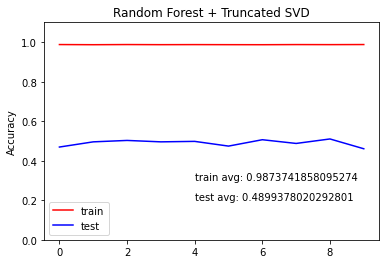

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from statistics import mean
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import string

from sklearn.ensemble import RandomForestClassifier


def preprocess_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]

    return " ".join(lemma_words)


def preprocess_corpus():
    companies = pd.read_csv("companies_and_social_media.csv")
    tweets = pd.read_csv("all_tweets.csv")
    companies = companies.dropna(subset=["Twitter"])
    twitter_score = companies.set_index("Twitter").to_dict()["Performance.Band"]
    tweets["score"] = tweets["user"].map(twitter_score)
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    corpus = tweets[["user", "content", "score"]]
    return corpus


def develop_model():
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"], corpus["score"], test_size=0.2)

    kf = KFold(n_splits=10,shuffle=True, random_state = 0)
    kf.split(corpus['content'])

    # Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
    train_acc_list = []
    test_acc_list = []
    f1_score_list = []
 
    # Iterate over each train-test split
    for train_index, test_index in kf.split(corpus['content']):
        # Split train-test
        train_set, test_set = corpus['content'].iloc[train_index], corpus['content'].iloc[test_index]
        train_label, test_label = corpus['score'].iloc[train_index], corpus['score'].iloc[test_index]
    
    
        encoder = LabelEncoder()
        encoder.fit(corpus["score"])
        test_label = encoder.transform(test_label)
        train_label = encoder.transform(train_label)

        tfidf_vect = TfidfVectorizer()
        tfidf_vect.fit(corpus["content"])
        train_set_tfidf = tfidf_vect.transform(train_set)
        test_set_tfidf = tfidf_vect.transform(test_set)
        
        
        ## Apply Truncated SVD to reduce dimensionality, since PCA didn't work with sparse data
        from sklearn.decomposition import TruncatedSVD
        svd = TruncatedSVD(n_components = 3500)
        svd.fit(train_set_tfidf)
        train_set_tfidf = svd.transform(train_set_tfidf)
        test_set_tfidf = svd.transform(test_set_tfidf)

        clf = RandomForestClassifier()
        clf.fit(train_set_tfidf, train_label)
        train_predictions = clf.predict(train_set_tfidf)
        test_predictions = clf.predict(test_set_tfidf)
        
        train_accuracy = accuracy_score(train_predictions, train_label)
        test_accuracy = accuracy_score(test_predictions, test_label)
        f1 = f1_score(test_label, test_predictions, average = 'micro')
        
        train_acc_list.append(train_accuracy)
        test_acc_list.append(test_accuracy)
        f1_score_list.append(f1)
        
        print('train accuracy: ', train_accuracy)
        print('test accuracy: ', test_accuracy)
        print('f1 score: ', f1)
    
    
    train_avg = 'train avg: ' + str(mean(train_acc_list))
    test_avg = 'test avg: ' + str(mean(test_acc_list))
    f1_avg = 'f1 avg: ' + str(mean(f1_score_list))
    
    
    plt.plot(train_acc_list, color = 'r', label = 'train')
    plt.ylabel('Accuracy')
    plt.plot(test_acc_list, color = 'b', label = 'test')
    ax = plt.gca()
    #plt.plot(f1_score_list, color = 'g', label = 'f1')
    ax.set_ylim([0, 1.1])
    plt.legend()
    plt.text(4, 0.3, train_avg)
    plt.text(4, 0.2, test_avg)
    #plt.text(4, 0.1, f1_avg)
    plt.title('Random Forest + Truncated SVD')
    plt.show()
    

'''    d = {"content": train_set, "prediction": train_label}
    f = {"content": test_set, "prediction": test_label}
    df = pd.DataFrame(data=d)
    df2 = pd.DataFrame(data=f)
    df = df.append(df2, ignore_index=True)
    tweets_summary = corpus.join(df.set_index("content"), on="content")

    tweets_summary["score"] = encoder.transform(tweets_summary["score"].tolist())
    companies = np.unique(tweets_summary["user"])
    companies_summary = pd.DataFrame(columns=["user", "score", "prediction"])
    for entry in companies:
        company = tweets_summary[tweets_summary["user"] == entry]
        companies_summary = companies_summary.append({"user": entry, "score": company["score"].mode(), "prediction": company["prediction"].mode()}, ignore_index=True)
    print(accuracy_score(np.array(companies_summary["score"].tolist()), np.array(companies_summary["prediction"].tolist())))

    tweets_summary["score"] = encoder.inverse_transform(tweets_summary["score"].tolist())
    tweets_summary["prediction"] = encoder.inverse_transform(tweets_summary["prediction"].tolist())
    companies_summary["score"] = encoder.inverse_transform(companies_summary["score"].tolist())
    companies_summary["prediction"] = encoder.inverse_transform(companies_summary["prediction"].tolist())

    tweets_summary.to_csv("tweets_summary.csv")
    companies_summary.to_csv("companies_summary.csv")'''


def main():
    develop_model()



if __name__ == '__main__':
    main()

Linear Regression

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


train score:  0.9741258286404925
test score:  -27.12543147200532
train score:  0.9742312458110715
test score:  -42.403592309788465
train score:  0.9727379048704563
test score:  -43.55442023592667
train score:  0.9735863888789458
test score:  -39.54319193213507
train score:  0.9751305721554273
test score:  -140.42450547152666
train score:  0.9754595888348804
test score:  -123.55628228367046
train score:  0.975517296341439
test score:  -45.03100002244644
train score:  0.9790567719284592
test score:  -68.62030963517378
train score:  0.9752920352313643
test score:  -31.14906096916973
train score:  0.9753353225954491
test score:  -25.327907733323904


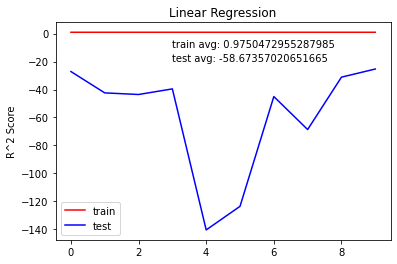

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from statistics import mean

from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
import re
from sklearn import model_selection, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import string


def preprocess_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]

    return " ".join(lemma_words)


def preprocess_corpus():
    companies = pd.read_csv("companies_and_social_media.csv")
    tweets = pd.read_csv("all_tweets.csv")
    companies = companies.dropna(subset=["Twitter", "Scope.1..metric.tonnes.CO2e."])
    twitter_emission = companies.set_index("Twitter").to_dict()["Scope.1..metric.tonnes.CO2e."]
    tweets["emission"] = tweets["user"].map(twitter_emission)
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    corpus = tweets[["user", "content", "emission"]]
    corpus = corpus.dropna(subset=["emission"])
    return corpus


def generate_sets(test_size):
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"],
                                                                                    corpus["emission"], test_size=test_size)
    tfidf_vect = TfidfVectorizer()
    tfidf_vect.fit(corpus["content"])
    train_set_tfidf = tfidf_vect.transform(train_set)
    test_set_tfidf = tfidf_vect.transform(test_set)
    return train_set_tfidf, test_set_tfidf, train_label, test_label


def develop_model():
    
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"],
                                                                                    corpus["emission"], test_size=0.2)
    
    # Create K fold cross validation with K = 10
    kf = KFold(n_splits=10,shuffle=True, random_state = 0)
    kf.split(corpus['content'])

    # Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
    train_acc_list = []
    test_acc_list = []
    f1_score_list = []
    
    for train_index, test_index in kf.split(corpus['content']):
        
        # Split train-test
        train_set, test_set = corpus['content'].iloc[train_index], corpus['content'].iloc[test_index]
        train_label, test_label = corpus["emission"].iloc[train_index], corpus["emission"].iloc[test_index]
    
        tfidf_vect = TfidfVectorizer()
        tfidf_vect.fit(corpus["content"])
        train_set_tfidf = tfidf_vect.transform(train_set)
        test_set_tfidf = tfidf_vect.transform(test_set)

        # Create model, train it, and predict
        rm = linear_model.LinearRegression()
        rm.fit(train_set_tfidf, train_label)
        train_predictions = rm.predict(train_set_tfidf)
        test_predictions = rm.predict(test_set_tfidf)

        train_score = rm.score(train_set_tfidf, train_label)
        test_score = rm.score(test_set_tfidf, test_label)
        
        train_acc_list.append(train_score)
        test_acc_list.append(test_score)
        
        print('train score: ', train_score)
        print('test score: ', test_score)
        
        
    train_avg = 'train avg: ' + str(mean(train_acc_list))
    test_avg = 'test avg: ' + str(mean(test_acc_list))
    
    
    plt.plot(train_acc_list, color = 'r', label = 'train')
    plt.ylabel('R^2 Score')
    plt.plot(test_acc_list, color = 'b', label = 'test')
    ax = plt.gca()
    plt.legend()
    plt.text(3, -10, train_avg)
    plt.text(3, -20, test_avg)
    plt.title('Linear Regression')
    plt.show()

    return train_score, test_score


def main():
    develop_model()



if __name__ == '__main__':
    main()

Linear Regression + Truncated SVD

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


train score:  0.6862330511323959
test score:  0.4743934194089565
train score:  0.6933562433677172
test score:  0.36666020399760946
train score:  0.6803855674725416
test score:  0.48102552843479573
train score:  0.6895985876987251
test score:  0.40575804731580845
train score:  0.6894279935625323
test score:  0.43173849849103096
train score:  0.6829170482376741
test score:  0.5269494659706349
train score:  0.685080747392299
test score:  0.463206062793754
train score:  0.6904180505245111
test score:  0.43263807129722265
train score:  0.6907758503545578
test score:  0.42190386782416567
train score:  0.6748391377469458
test score:  0.520215188425611


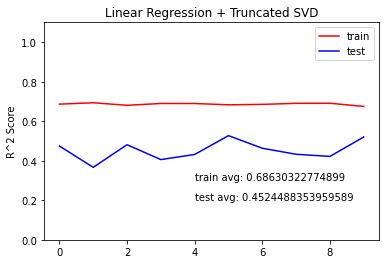

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from statistics import mean

from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
import re
from sklearn import model_selection, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import string


def preprocess_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]

    return " ".join(lemma_words)


def preprocess_corpus():
    companies = pd.read_csv("companies_and_social_media.csv")
    tweets = pd.read_csv("all_tweets.csv")
    companies = companies.dropna(subset=["Twitter", "Scope.1..metric.tonnes.CO2e."])
    twitter_emission = companies.set_index("Twitter").to_dict()["Scope.1..metric.tonnes.CO2e."]
    tweets["emission"] = tweets["user"].map(twitter_emission)
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    corpus = tweets[["user", "content", "emission"]]
    corpus = corpus.dropna(subset=["emission"])
    return corpus


def generate_sets(test_size):
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"],
                                                                                    corpus["emission"], test_size=test_size)
    tfidf_vect = TfidfVectorizer()
    tfidf_vect.fit(corpus["content"])
    train_set_tfidf = tfidf_vect.transform(train_set)
    test_set_tfidf = tfidf_vect.transform(test_set)
    return train_set_tfidf, test_set_tfidf, train_label, test_label


def develop_model():
    
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"],
                                                                                    corpus["emission"], test_size=0.2)
    
    # Create K fold cross validation with K = 10
    kf = KFold(n_splits=10,shuffle=True, random_state = 0)
    kf.split(corpus['content'])

    # Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
    train_acc_list = []
    test_acc_list = []
    f1_score_list = []
    
    for train_index, test_index in kf.split(corpus['content']):
        
        # Split train-test
        train_set, test_set = corpus['content'].iloc[train_index], corpus['content'].iloc[test_index]
        train_label, test_label = corpus["emission"].iloc[train_index], corpus["emission"].iloc[test_index]
    
        tfidf_vect = TfidfVectorizer()
        tfidf_vect.fit(corpus["content"])
        train_set_tfidf = tfidf_vect.transform(train_set)
        test_set_tfidf = tfidf_vect.transform(test_set)
        
        # Truncated SVD
        dr = TruncatedSVD(n_components=4000)
        train_set_tfidf = dr.fit_transform(train_set_tfidf)
        test_set_tfidf = dr.transform(test_set_tfidf)

        # Create model, train it, and predict
        rm = linear_model.LinearRegression()
        rm.fit(train_set_tfidf, train_label)
        train_predictions = rm.predict(train_set_tfidf)
        test_predictions = rm.predict(test_set_tfidf)

        train_score = rm.score(train_set_tfidf, train_label)
        test_score = rm.score(test_set_tfidf, test_label)
        
        train_acc_list.append(train_score)
        test_acc_list.append(test_score)
        
        print('train score: ', train_score)
        print('test score: ', test_score)
        
        
    train_avg = 'train avg: ' + str(mean(train_acc_list))
    test_avg = 'test avg: ' + str(mean(test_acc_list))
    
    
    plt.plot(train_acc_list, color = 'r', label = 'train')
    plt.ylabel('R^2 Score')
    plt.plot(test_acc_list, color = 'b', label = 'test')
    ax = plt.gca()
    ax.set_ylim([0, 1.1])
    plt.legend()
    plt.text(4, 0.3, train_avg)
    plt.text(4, 0.2, test_avg)
    plt.title('Linear Regression + Truncated SVD')
    plt.show()

    return train_score, test_score


def main():
    develop_model()



if __name__ == '__main__':
    main()

Case Study - Predict grade of 8 "secretive companies" using the best performing model (Random Forest)

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from statistics import mean
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import string

from sklearn.ensemble import RandomForestClassifier


def preprocess_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]

    return " ".join(lemma_words)


def preprocess_corpus():
    companies = pd.read_csv("companies_and_social_media.csv")
    tweets = pd.read_csv("all_tweets.csv")
    companies = companies.dropna(subset=["Twitter"])
    twitter_score = companies.set_index("Twitter").to_dict()["Performance.Band"]
    tweets["score"] = tweets["user"].map(twitter_score)
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    corpus = tweets[["user", "content", "score"]]
    return corpus

def case_study_process():
    tweets = pd.read_csv("case_study_tweets.csv")
    tweets["content"] = tweets["content"].apply(preprocess_tweet)
    case_study_corpus = tweets[["user", "content"]]
    return case_study_corpus


def develop_model():
    # Process corpus, split train and test sets
    corpus = preprocess_corpus()
    train_set, test_set, train_label, test_label = model_selection.train_test_split(corpus["content"], corpus["score"], 
                                                                                    test_size=0.2, random_state = 0)
    # Clean case study data
    case_study_corpus = case_study_process()
    case_study = case_study_corpus['content']

    encoder = LabelEncoder()
    encoder.fit(corpus["score"])
    test_label = encoder.transform(test_label)
    train_label = encoder.transform(train_label)

    tfidf_vect = TfidfVectorizer()
    tfidf_vect.fit(corpus["content"])
    train_set_tfidf = tfidf_vect.transform(train_set)
    test_set_tfidf = tfidf_vect.transform(test_set)
    
    case_study_tfidf = tfidf_vect.transform(case_study)
    

    clf = RandomForestClassifier()
    clf.fit(train_set_tfidf, train_label)
    train_predictions = clf.predict(train_set_tfidf)
    test_predictions = clf.predict(test_set_tfidf)
    
    case_study_pred = clf.predict(case_study_tfidf)
    
    train_accuracy = accuracy_score(train_predictions, train_label)
    test_accuracy = accuracy_score(test_predictions, test_label)

    print('train accuracy: ', train_accuracy)
    print('test accuracy: ', test_accuracy)
    
    # Predict the grade of all the case study tweets and add this prediction as a column
    case_study_corpus['prediction'] = case_study_pred
    cs_tweets = case_study_corpus

    # Get the mode of all tweet grades for each company
    # This is the predicted grade for the company as a whole
    companies = np.unique(cs_tweets["user"])
    companies_summary = pd.DataFrame(columns=["user", "prediction"])
    for entry in companies:
        company = cs_tweets[cs_tweets["user"] == entry]
        companies_summary = companies_summary.append({"user": entry, "prediction": company["prediction"].mode()}, ignore_index=True)
    
    # Reverse the encoding so that the grades go from numbers to grades again
    cs_tweets["prediction"] = encoder.inverse_transform(cs_tweets["prediction"].tolist())
    companies_summary["prediction"] = encoder.inverse_transform(companies_summary["prediction"].tolist())

    # Record the grade for each tweet and the grade for each company in csv files
    cs_tweets.to_csv("case_study_tweets_summary.csv")
    companies_summary.to_csv("case_study_companies_summary.csv")


def main():
    develop_model()



if __name__ == '__main__':
    main()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jcaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


train accuracy:  0.9873852355004852
test accuracy:  0.7319402985074627


C:\Users\jcaza\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
